### Regression

**Census Data 2020**

In [1]:
#import census data
!pip install census
!pip install us
!pip install geopandas

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
from pyproj import Proj, transform

from census import Census
from us import states
import os
import datetime

import statsmodels.formula.api as smf

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 669.5 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for us: filename=us-2.0.2-py3-none-any.whl size=11945 sha256=c1bd77ac33e262f766106a4fba61d5d14bcb5f405c24ab3e00fcb840f16dafeb
  Stored in directory: /root/.cache/pip/wheels/ca/6b/11/cda9ea2438f721330a35c9a2c8e34b4aedcd34c89af48a4d00
  Created wheel for jellyfish: filename=jellyfish-0.6.1-cp37-cp37m-linux_x86_64.whl size=97829 sha256=0f274f30e4b93cb5d40c55c5d0127489c8fe25204e0b984feaabf1ffb95e18b6
  Stored in directory: /root/.cache/pip/wheels/a1/99/51/7de469e37cd1b3c763c24394e1ebf1baa2d79e094bf346cf80
Successfully built us jellyfish


/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [83]:
# Set API key
c = Census("9539dae04d950aa6ea780553e4526f196063785c")

List of variables in ACS: https://api.census.gov/data/2019/acs/acs5/variables.html
<br>
NY ID: states.NY.fips - 36
<br>
NYC Counties:  New York County (Manhattan), Kings County (Brooklyn), Bronx County (The Bronx), Richmond County (Staten Island), and Queens County (Queens)
<br><br>
**Variables** <br>
B01003_001e: POPULATION <br>
B07013_002E: Householder lived in owner-occupied housing units<br>
B07013_003E: Householder lived in renter-occupied housing units<br>
B08015_001E:Aggregate number of vehicles (car, truck, or van) used in commuting<br>
<br><br>
NY Census tract: https://www2.census.gov/geo/tiger/TIGER2020/TRACT/

In [4]:
ny_census = c.acs5.state_county_tract(fields = ('NAME', 'B01003_001E', 'B07013_002E', 'B07013_003E', 'B08015_001E'),
                                      state_fips = states.NY.fips,
                                      county_fips = "*",
                                      tract = "*",
                                      year = 2020)

In [5]:
#put census data into dataframe
ny_df = pd.DataFrame(ny_census)
#select nyc county
ny_countyid = ['061','005','047','081', '085']
ny_df = ny_df[ny_df.county.isin(ny_countyid)]
# Combine state, county, and tract columns together to create a new string and assign to new column
ny_df["GEOID"] = ny_df["state"] + ny_df["county"] + ny_df["tract"]
# Remove columns
ny_df = ny_df.drop(columns = ["state", "county", "tract"])

print(ny_df.columns)
print('Shape: ', ny_df.shape)

Index(['NAME', 'B01003_001E', 'B07013_002E', 'B07013_003E', 'B08015_001E',
       'GEOID'],
      dtype='object')
Shape:  (2327, 6)


In [6]:
#import shapefile
# Access shapefile of Virginia census tracts
ny_tract = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2020/TRACT/tl_2020_36_tract.zip")

# Reproject shapefile
ny_tract = ny_tract.to_crs(epsg = 2263)

# Print GeoDataFrame of shapefile
print('Shape: ', ny_tract.shape)

# Check shapefile projection
print("\nThe shapefile projection is: {}".format(ny_tract.crs))

Shape:  (5411, 13)

The shapefile projection is: epsg:2263


In [7]:
#only select NYC census tract
ny_merge = ny_tract.merge(ny_df, on = "GEOID", how = 'inner')

# Show result
print('Shape: ', ny_merge.shape)

Shape:  (2327, 18)


In [8]:
# Create new dataframe from select columns
ny_acs_tract = ny_merge[["STATEFP", "COUNTYFP", "TRACTCE", "GEOID", "geometry", 'ALAND',"B01003_001E", "B07013_002E", "B07013_003E", "B08015_001E"]]

ny_acs_tract.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,geometry,ALAND,B01003_001E,B07013_002E,B07013_003E,B08015_001E
0,36,047,000700,36047000700,"POLYGON ((983822.387 191677.069, 983884.784 19...",176774,3899.0,1739.0,2019.0,80.0
1,36,047,000900,36047000900,"POLYGON ((985901.155 190988.903, 985987.108 19...",163469,4654.0,1413.0,2763.0,NaN
2,36,047,001100,36047001100,"POLYGON ((986821.216 191772.656, 986899.113 19...",168507,1502.0,131.0,1335.0,NaN
3,36,047,001300,36047001300,"POLYGON ((986632.168 193807.053, 986660.709 19...",293167,1917.0,1425.0,326.0,85.0
4,36,047,002000,36047002000,"POLYGON ((979067.973 175146.581, 979229.520 17...",154138,1503.0,237.0,1224.0,NaN


Text(0.5, 1.0, 'Population in NYC')

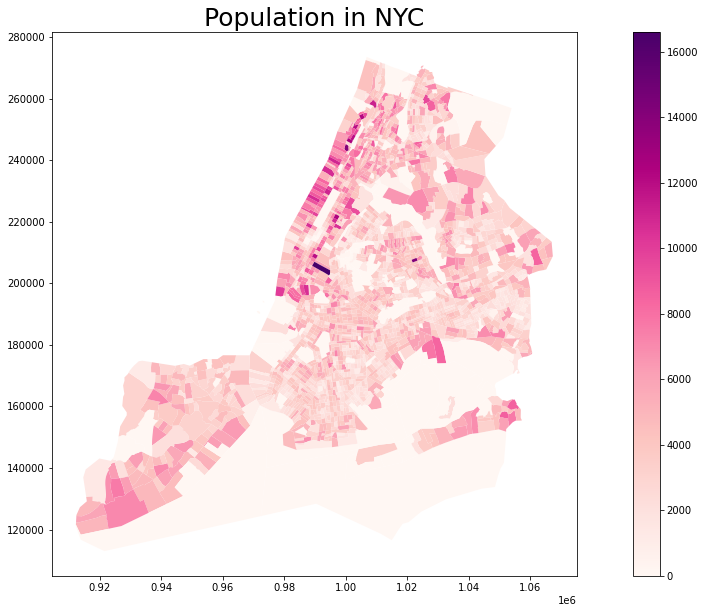

In [9]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

# Plot data
# Source: https://geopandas.readthedocs.io/en/latest/docs/user_guide/mapping.html
ny_acs_tract.plot(column = "B01003_001E",
                       ax = ax,
                       cmap = "RdPu",
                       legend = True)

# Stylize plots
plt.style.use('bmh')

# Set title
ax.set_title('Population in NYC', fontdict = {'fontsize': '25', 'fontweight' : '3'})

### Weather data

In [10]:
weather_df = pd.read_csv('/kaggle/input/nyc-weather/new york 2021-01-01 to 2022-09-30.csv')
weather_df = weather_df[['datetime','temp','humidity','windspeed']]
weather_df.columns = ['date','temp','humidity','windspeed']
weather_df.date = pd.to_datetime(weather_df.date)
weather_df.date = weather_df.date.dt.date
weather_df = weather_df[weather_df.date >= datetime.date(2022,1,1)]
weather_df = weather_df.groupby('date').mean()
weather_df.shape

(273, 3)

### Subway data

In [11]:
subway_df = gpd.read_file('/kaggle/input/subwaystation/subwayStation.csv')
subway_df = subway_df[['OBJECTID','the_geom']]
subway_df['lat'] = subway_df['the_geom'].apply(lambda x: x.split()[2][:-1]).astype('float')
subway_df['lng'] = subway_df['the_geom'].apply(lambda x: x.split()[1][1:]).astype('float')

#convert projection system
inProj = Proj("+init=EPSG:4326",preserve_units=True) # WGS84 in degrees
outProj  = Proj("+init=EPSG:2263") #epsg:2263 The New York State Plane Long Island Zone

y,x=inProj(subway_df.lat.values,subway_df.lng.values)
lon, lat = transform(inProj,outProj,x,y)
#convert to geopadas dataframe 
#crs: coordinate reference system  
geoSbwy = gpd.GeoDataFrame(subway_df,
                geometry=gpd.points_from_xy(lon, lat, crs="EPSG:2263"))

geoSbwy = geoSbwy[['OBJECTID','geometry']]
geoSbwy.head()

/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:292: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:292: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  # This is added back by InteractiveShell

,OBJECTID,geometry
0,1,POINT (986725.002 205255.053)
1,2,POINT (984196.500 201155.840)
2,3,POINT (988724.216 216795.191)
3,4,POINT (991184.246 187333.844)
4,5,POINT (1013411.541 181467.289)


In [12]:
#spatial join
geoSbwy_join = geoSbwy.sjoin(ny_acs_tract, op='within', how='inner')
geoSbwy_join.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


,OBJECTID,geometry,index_right,STATEFP,COUNTYFP,TRACTCE,GEOID,ALAND,B01003_001E,B07013_002E,B07013_003E,B08015_001E
0,1,POINT (986725.002 205255.053),359,36,061,005700,36061005700,108047,2887.0,1221.0,1633.0,105.0
400,401,POINT (986326.439 205404.755),359,36,061,005700,36061005700,108047,2887.0,1221.0,1633.0,105.0
1,2,POINT (984196.500 201155.840),353,36,061,004500,36061004500,104948,1040.0,558.0,477.0,NaN
416,417,POINT (983743.833 201397.032),353,36,061,004500,36061004500,104948,1040.0,558.0,477.0,NaN
434,435,POINT (983957.631 201159.945),353,36,061,004500,36061004500,104948,1040.0,558.0,477.0,NaN


In [13]:
# group by census tract
geoSbwy_count = geoSbwy_join.groupby('GEOID').count()[['OBJECTID']]
geoSbwy_count.columns = ['SubwayCount']
geoSbwy_count.head()

,SubwayCount
GEOID,
36005002300,1
36005002702,1
36005003100,1
36005003900,1
36005004800,1


### Citibike data

In [ ]:
# #for whole NYC
# bike_df = pd.read_csv('/kaggle/input/citibike-2022/citibike_data_2022/202209-citibike-tripdata.csv')
# #bike_df[~bike_df.columns.isin(['end_lat','end_lng','member_casual'])]
# bike_start = bike_df.loc[:, ~bike_df.columns.isin(['ended_at', 'end_station_name', 'end_station_id', 
#                                                   'end_lat','end_lng','member_casual'])]
# bike_end = bike_df.loc[:, ~bike_df.columns.isin(['started_at', 'start_station_name', 'start_station_id', 
#                                                   'start_lat','start_lng','member_casual'])]
# bike_end.head()

# #end
# #convert projection system
# inProj = Proj("+init=EPSG:4326",preserve_units=True) # WGS84 in degrees
# outProj  = Proj("+init=EPSG:2263") #epsg:2263 The New York State Plane Long Island Zone

# y,x=inProj(bike_end.end_lat.values,bike_end.end_lng.values)
# lon, lat = transform(inProj,outProj,x,y)

# #convert to geopadas dataframe 
# #crs: coordinate reference system  
# geoBike_end = gpd.GeoDataFrame(bike_end,
#                 geometry=gpd.points_from_xy(lon, lat, crs="EPSG:2263"))

# #start
# #convert projection system
# y1,x1=inProj(bike_start.start_lat.values,bike_start.start_lng.values)
# lon, lat = transform(inProj,outProj,x1,y1)

# #convert to geopadas dataframe 
# #crs: coordinate reference system  
# geoBike_start = gpd.GeoDataFrame(bike_start,
#                 geometry=gpd.points_from_xy(lon, lat, crs="EPSG:2263"))
# geoBike_start.head()

In [25]:
#all citibike data starting from Brooklyn
bike_bk_df = pd.read_csv('/kaggle/input/citibikebk/cleancitibike.csv')
bike_bk_df = bike_bk_df.loc[:, ~bike_bk_df.columns.isin(['Unnamed: 0','Unnamed: 0.1','rideable_type','start_station_name',
                                                         'ended_at', 'end_station_name', 'end_station_id', 
                                                          'end_lat','end_lng','member_casual','index_right','startpoint',
                                                         'ZIPCODE','COUNTY'])]
#convert projection system
inProj = Proj("+init=EPSG:4326",preserve_units=True) # WGS84 in degrees
outProj  = Proj("+init=EPSG:2263") #epsg:2263 The New York State Plane Long Island Zone

y,x=inProj(bike_bk_df.start_lat.values,bike_bk_df.start_lng.values)
lon, lat = transform(inProj,outProj,x,y)

#convert to geopadas dataframe 
#crs: coordinate reference system  
geoBike = gpd.GeoDataFrame(bike_bk_df,
                geometry=gpd.points_from_xy(lon, lat, crs="EPSG:2263"))
geoBike.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (7,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:292: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/opt/conda/lib/python3.7/site-packages/pyproj/crs/crs.py:292: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)
/opt/conda/lib/pyth

,ride_id,started_at,start_station_id,start_lat,start_lng,time_diff,geometry
0,BF6CDCF4CE947A03,2021-10-24 10:20:22,3704.04,40.663657,-73.963014,0.008218,POINT (994511.099 181066.699)
1,B3069B771E97BDDC,2021-10-17 12:36:06,3498.09,40.657265,-73.974165,0.012396,POINT (991418.142 178736.806)
2,054227EA5080C418,2021-10-06 13:19:26,3928.08,40.671649,-73.963115,0.004410,POINT (994481.991 183978.508)
3,77959BBA5E75641A,2021-10-31 15:48:26,5542.04,40.723250,-73.943080,0.015833,POINT (1000027.319 202781.144)
4,53B0F93C6F404AED,2021-10-24 10:25:00,4513.06,40.689888,-73.981013,0.006458,POINT (989515.530 190621.810)


In [26]:
geoBike = geoBike.sjoin(ny_acs_tract, op='within', how='inner')
geoBike = geoBike.loc[:, ~geoBike.columns.isin(['index_right',
                                                'STATEFP','COUNTYFP','TRACTCE'])]
geoBike['started_at'] = pd.to_datetime(geoBike['started_at']).dt.date
print(geoBike.shape)
geoBike.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


(6561575, 13)


,ride_id,started_at,start_station_id,start_lat,start_lng,time_diff,geometry,GEOID,ALAND,B01003_001E,B07013_002E,B07013_003E,B08015_001E
0,BF6CDCF4CE947A03,2021-10-24,3704.04,40.663657,-73.963014,0.008218,POINT (994511.099 181066.699),36047017700,2313048,0.0,0.0,0.0,-666666666.0
2,054227EA5080C418,2021-10-06,3928.08,40.671649,-73.963115,0.004410,POINT (994481.991 183978.508),36047017700,2313048,0.0,0.0,0.0,-666666666.0
6,281CC7B315D4AA41,2021-10-28,3344.02,40.651566,-73.972212,0.010081,POINT (991960.677 176660.668),36047017700,2313048,0.0,0.0,0.0,-666666666.0
7,6B1A8A0B2B9B8037,2021-10-02,3344.02,40.651566,-73.972212,0.007083,POINT (991960.677 176660.668),36047017700,2313048,0.0,0.0,0.0,-666666666.0
8,CC264C5073D9F6E3,2021-10-11,3344.02,40.651566,-73.972212,0.007708,POINT (991960.677 176660.668),36047017700,2313048,0.0,0.0,0.0,-666666666.0


#### Daily usage regression

In [56]:
dir_ = '/kaggle/input/citibike-2022/citibike_data_2022/'
# get all the csv files in that directory (assuming they have the extension .csv)
os.listdir(dir_)
dataframes = []  # a list to hold all the individual pandas DataFrames
for csvfile in os.listdir(dir_):
    print(csvfile)
    bike = pd.read_csv(dir_+csvfile)
    bike = bike[['ride_id','started_at']]
    bike['started_at'] = pd.to_datetime(bike['started_at'])
    bike['date'] = bike['started_at'].dt.date
    bike = bike.groupby('date').count()[['ride_id']]
    dataframes.append(bike)
        
# concatenate them all together
bikeDaily_df = pd.concat(dataframes)
bikeDaily_df.shape

202201-citibike-tripdata.csv


/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


202202-citibike-tripdata.csv
202204-citibike-tripdata.csv
202205-citibike-tripdata.csv
202207-citbike-tripdata.csv
202203-citibike-tripdata.csv
202206-citbike-tripdata.csv
202209-citibike-tripdata.csv
202208-citibike-tripdata.csv


(273, 1)

In [57]:
daily_df = bikeDaily_df.merge(weather_df,on='date')
#weekday
daily_df['weekday'] = pd.Series(daily_df.index,index=daily_df.index).apply(lambda x: x.weekday())
daily_df['Isweekend'] = daily_df['weekday'].apply(lambda x: 1 if x>=5 else 0)
daily_df = daily_df[['ride_id', 'temp', 'humidity', 'windspeed', 'Isweekend']]
daily_df.columns = ['RideCount', 'temp', 'humidity', 'windspeed', 'Isweekend']

In [59]:
#correlation 
corr_daily = daily_df.corr()
corr_daily

,RideCount,temp,humidity,windspeed,Isweekend
RideCount,1.000000,0.883520,-0.073915,-0.275239,-0.105006
temp,0.883520,1.000000,0.165814,-0.244578,-0.036577
humidity,-0.073915,0.165814,1.000000,-0.066400,-0.041268
windspeed,-0.275239,-0.244578,-0.066400,1.000000,-0.003769
Isweekend,-0.105006,-0.036577,-0.041268,-0.003769,1.000000


In [66]:
def linearRegVar(data, y, var_list, log=False, Figure=True):
    #create a dataframe for report results
    report = pd.DataFrame(columns=['slope', 'intercept','R2'])
    
    for var in var_list:
        if log:
            logvar = np.log(data[var])
            logy = np.log(data[y])
            data1 = pd.DataFrame({y:logy, var:logvar})
            data1 = data1[data1[var]!=data1[var].min()]
            #print(data1.head())
        else:
            data1 = data.copy()
        lm = smf.ols(formula= y+'~'+var, data = data1).fit()
        #add the prediction line
        if Figure:
            fig, ax = plt.subplots() #get axis to plot on
            data1.plot(ax=ax,kind='scatter',x=var, y=y, title='{} vs {}'.format(y,var)) #show the data
            ax.plot(data1[var],lm.predict(),'r-'); #show the regression line
        
        row = pd.Series({'slope':lm.params[1], 'intercept':lm.params[0], 'R2':lm.rsquared},
                name=var)
        report = report.append(row)
    return report

In [80]:
#normalize
norm_val = []
for col in ['RideCount', 'temp', 'humidity', 'windspeed']:
    norm = col+'Norm'
    daily_df[norm] = (daily_df[col]-daily_df[col].mean())/daily_df[col].std()
    if col !='RideCount':
        norm_val.append(norm)

,slope,intercept,R2
temp,3084.140519,39804.538235,0.780608
humidity,-182.217424,97302.851374,0.005463
windspeed,-1549.044251,118542.773594,0.075757
Isweekend,-8160.928205,88626.543590,0.011026


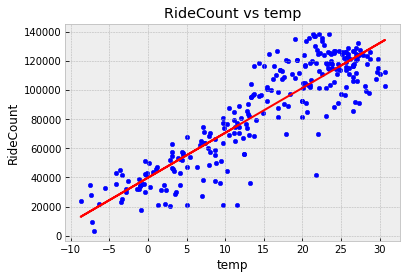

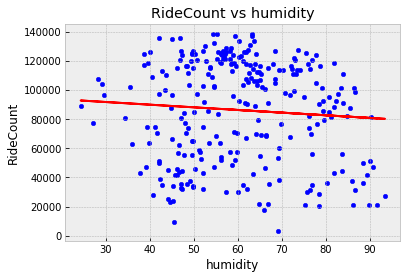

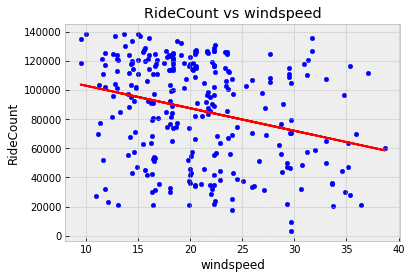

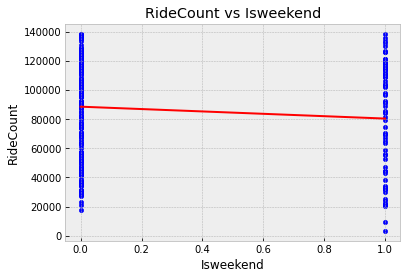

In [69]:
var_list = ['temp', 'humidity', 'windspeed', 'Isweekend']
linearRegVar(daily_df, 'RideCount', var_list)

In [82]:
norm_val += ['Isweekend']
linearRegVar(daily_df, 'RideCountNorm', norm_val, Figure=False)

,slope,intercept,R2
tempNorm,0.883520,-8.153200e-17,0.780608
humidityNorm,-0.073915,-8.153200e-17,0.005463
windspeedNorm,-0.275239,-8.153200e-17,0.075757
Isweekend,-0.232014,6.628979e-02,0.011026


### Regression at census tract level

In [72]:
geoBike_count = geoBike.groupby('GEOID')[['ride_id','start_station_id','time_diff','ALAND','B01003_001E','B07013_002E',
                              'B07013_003E','B08015_001E']].agg({'ride_id':'count','start_station_id':'nunique','time_diff':'mean',
                                                                 'ALAND':'mean','B01003_001E':'sum','B07013_002E':'sum',
                                                                 'B07013_003E':'sum','B08015_001E':'sum'})
geoBike_count.columns = ['StartRideCount','StationCount','TimeUsage','Area','Population','HouseholdOwners','HouseholdRenter','CommutingInCar']

all_count = ny_acs_tract.merge(geoBike_count, how='left', on='GEOID')
all_count = all_count.merge(geoSbwy_count, how='left', on='GEOID')
all_count = all_count[['GEOID','StartRideCount','StationCount','TimeUsage','Area','Population','HouseholdOwners',
                       'HouseholdRenter','CommutingInCar','SubwayCount']]

#fill null and drop null by population
all_count["SubwayCount"].fillna(0, inplace = True)
all_count = all_count.dropna(subset=['Population'])
all_count = all_count[all_count.Population!=0]
all_count = all_count[all_count.CommutingInCar>=0]

all_count['RideDensity'] = all_count['StartRideCount']/all_count['Population']
all_count['PopDensity'] = all_count['Population']/all_count['Area']
all_count['Household'] = all_count['HouseholdOwners'] + all_count['HouseholdRenter']
all_count['HouseholdPerCap'] = all_count['Household']/all_count['Population']
print(all_count.shape)
all_count.head()
#all_count.isnull().sum()

(251, 14)


,GEOID,StartRideCount,StationCount,TimeUsage,Area,Population,HouseholdOwners,HouseholdRenter,CommutingInCar,SubwayCount,RideDensity,PopDensity,Household,HouseholdPerCap
0,36047000700,50728.0,11.0,0.011315,176774.0,197788472.0,88215992.0,102419832.0,4058240.0,0.0,0.000256,1118.877618,190635824.0,0.963837
1,36047000900,75861.0,25.0,0.010781,163469.0,353057094.0,107191593.0,209603943.0,0.0,2.0,0.000215,2159.780105,316795536.0,0.897293
2,36047001100,73438.0,13.0,0.013259,168507.0,110303876.0,9620378.0,98039730.0,0.0,3.0,0.000666,654.595216,107660108.0,0.976032
3,36047001300,63727.0,17.0,0.015709,293167.0,122164659.0,90810975.0,20775002.0,5416795.0,2.0,0.000522,416.706720,111585977.0,0.913406
4,36047002000,815.0,4.0,0.017817,154138.0,1224945.0,193155.0,997560.0,0.0,0.0,0.000665,7.947067,1190715.0,0.972056


In [73]:
selected_col = ['StartRideCount','TimeUsage','StationCount','CommutingInCar', 'SubwayCount', 'PopDensity','HouseholdPerCap']
corr_df = all_count[selected_col].corr()
corr_df

,StartRideCount,TimeUsage,StationCount,CommutingInCar,SubwayCount,PopDensity,HouseholdPerCap
StartRideCount,1.000000,-0.062892,0.747531,0.695475,0.157679,0.857207,-0.151888
TimeUsage,-0.062892,1.000000,0.020119,-0.008100,0.046109,-0.097107,0.029333
StationCount,0.747531,0.020119,1.000000,0.554012,0.138677,0.610252,-0.044556
CommutingInCar,0.695475,-0.008100,0.554012,1.000000,0.046374,0.645985,-0.047495
SubwayCount,0.157679,0.046109,0.138677,0.046374,1.000000,0.116888,-0.077912
PopDensity,0.857207,-0.097107,0.610252,0.645985,0.116888,1.000000,-0.158528
HouseholdPerCap,-0.151888,0.029333,-0.044556,-0.047495,-0.077912,-0.158528,1.000000


In [74]:
#normalize
norm_val = []
for col in selected_col:
    norm = col+'Norm'
    all_count[norm] = (all_count[col]-all_count[col].mean())/all_count[col].std()
    if col !='StartRideCount':
        norm_val.append(norm)

In [75]:
selected_col = norm_val + ['StartRideCount']
corr_df = all_count[selected_col].corr()
corr_df

,TimeUsageNorm,StationCountNorm,CommutingInCarNorm,SubwayCountNorm,PopDensityNorm,HouseholdPerCapNorm,StartRideCount
TimeUsageNorm,1.000000,0.020119,-0.008100,0.046109,-0.097107,0.029333,-0.062892
StationCountNorm,0.020119,1.000000,0.554012,0.138677,0.610252,-0.044556,0.747531
CommutingInCarNorm,-0.008100,0.554012,1.000000,0.046374,0.645985,-0.047495,0.695475
SubwayCountNorm,0.046109,0.138677,0.046374,1.000000,0.116888,-0.077912,0.157679
PopDensityNorm,-0.097107,0.610252,0.645985,0.116888,1.000000,-0.158528,0.857207
HouseholdPerCapNorm,0.029333,-0.044556,-0.047495,-0.077912,-0.158528,1.000000,-0.151888
StartRideCount,-0.062892,0.747531,0.695475,0.157679,0.857207,-0.151888,1.000000


### With Ride Count

,slope,intercept,R2
StationCount,3783.962339,-4735.482877,0.558802
TimeUsage,-541427.533443,31356.737228,0.003955
CommutingInCar,0.002894,12206.212459,0.483686
SubwayCount,7052.251047,21904.950824,0.024863
PopDensity,42.975142,3129.706933,0.734803
HouseholdPerCap,-89113.344517,110547.864184,0.023070


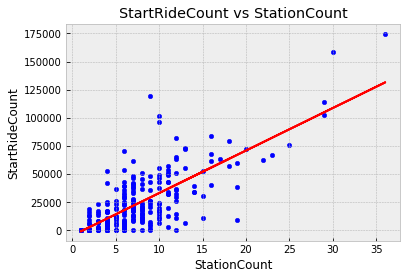

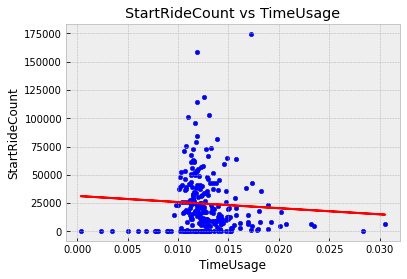

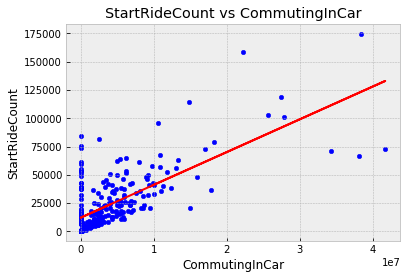

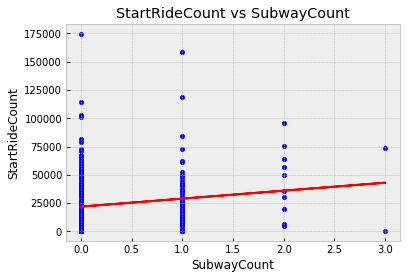

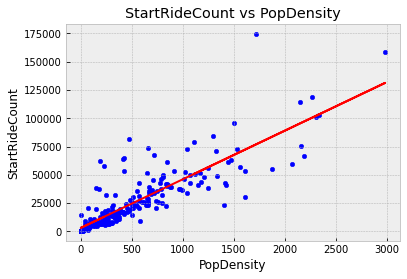

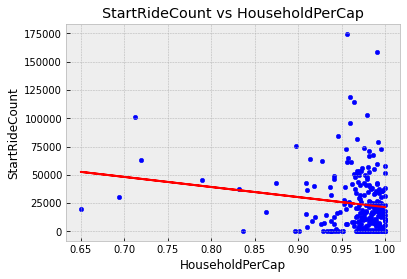

In [76]:
#linear regression with variables
varlist = ['StationCount','TimeUsage','CommutingInCar','SubwayCount','PopDensity','HouseholdPerCap']
linearRegVar(all_count, 'StartRideCount', varlist)

In [77]:
#normalize 
print(norm_val)
linearRegVar(all_count, 'StartRideCountNorm', norm_val, Figure=False)

['TimeUsageNorm', 'StationCountNorm', 'CommutingInCarNorm', 'SubwayCountNorm', 'PopDensityNorm', 'HouseholdPerCapNorm']


,slope,intercept,R2
TimeUsageNorm,-0.062892,-4.163336e-17,0.003955
StationCountNorm,0.747531,-4.163336e-17,0.558802
CommutingInCarNorm,0.695475,-4.163336e-17,0.483686
SubwayCountNorm,0.157679,-4.163336e-17,0.024863
PopDensityNorm,0.857207,-4.163336e-17,0.734803
HouseholdPerCapNorm,-0.151888,-4.163336e-17,0.023070


,slope,intercept,R2
PopDensity,0.984538,3.982429,0.957804


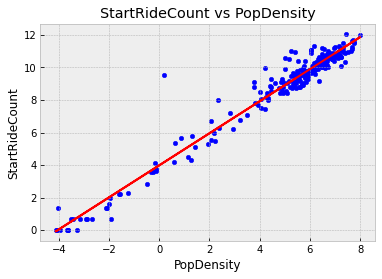

In [78]:
#log-scale
linearRegVar(all_count, 'StartRideCount', ['PopDensity'], log=True)

### Multi-variate regression

In [89]:
#with norm
#when consider the intercept the p-value=1, which is not statistically significant
lm_multiNorm = smf.ols(formula='StartRideCountNorm~StationCountNorm+CommutingInCarNorm+PopDensityNorm-1', data = all_count).fit()
print(lm_multiNorm.summary())

                                 OLS Regression Results                                
Dep. Variable:     StartRideCountNorm   R-squared (uncentered):                   0.828
Model:                            OLS   Adj. R-squared (uncentered):              0.826
Method:                 Least Squares   F-statistic:                              398.7
Date:                Wed, 14 Dec 2022   Prob (F-statistic):                    1.53e-94
Time:                        08:12:37   Log-Likelihood:                         -134.55
No. Observations:                 251   AIC:                                      275.1
Df Residuals:                     248   BIC:                                      285.7
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                         coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------

In [90]:
lm_multiNorm.params

StationCountNorm      0.317849
CommutingInCarNorm    0.156067
PopDensityNorm        0.562422
dtype: float64

In [94]:

print('RideCount~{}*StationCount+{}*CommutingInCar+{}*PopDensity'.format(lm_multiNorm.params[0],lm_multiNorm.params[1], lm_multiNorm.params[2]))

RideCount~0.31784900042170416*StationCount+0.15606680524703898*CommutingInCar+0.5624220162297197*PopDensity


In [95]:
all_count_viz = all_count[['StationCountNorm','CommutingInCarNorm','PopDensityNorm','StartRideCountNorm']]
all_count_viz['CountPred'] = all_count_viz['StationCountNorm']*lm_multiNorm.params[0]\
                                +all_count_viz['CommutingInCarNorm']*lm_multiNorm.params[1]+all_count_viz['PopDensityNorm']*lm_multiNorm.params[2]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<AxesSubplot:title={'center':'Observed vs Estimated on Normalized Count'}, xlabel='Observed', ylabel='Estimated'>

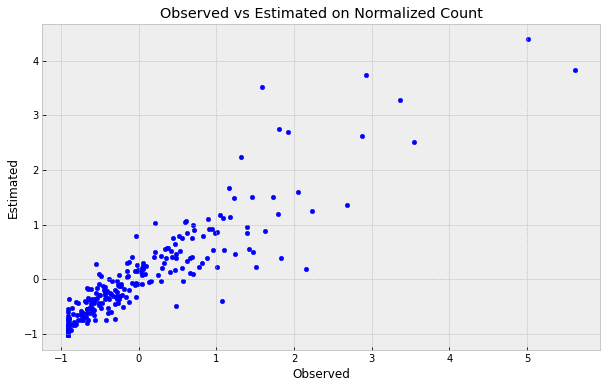

In [98]:
all_count_viz.plot(kind='scatter',x='StartRideCountNorm',xlabel='Observed',
                  y='CountPred',ylabel='Estimated',title='Observed vs Estimated on Normalized Count',figsize=(10,6))